In [97]:
import pandas as pd
import random
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [45]:
# read original dataset
alldata_df = pd.read_csv('all_data.csv')
alldata_df = alldata_df[['Genre','combined score']]
alldata_df
groups = alldata_df.groupby('Genre').count().reset_index().rename(columns={'combined score':'number_of_values'})
groups

,Genre,number_of_values
0,Control/No Music,4
1,Indian_Classical,5
2,Jazz,4
3,Pop,5
4,Rock,5
5,Western_Classical,4


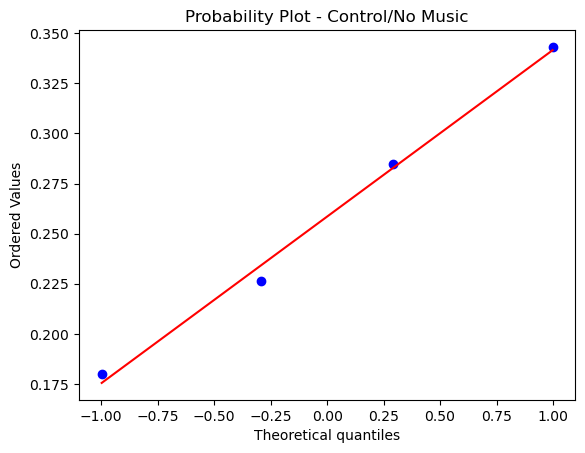

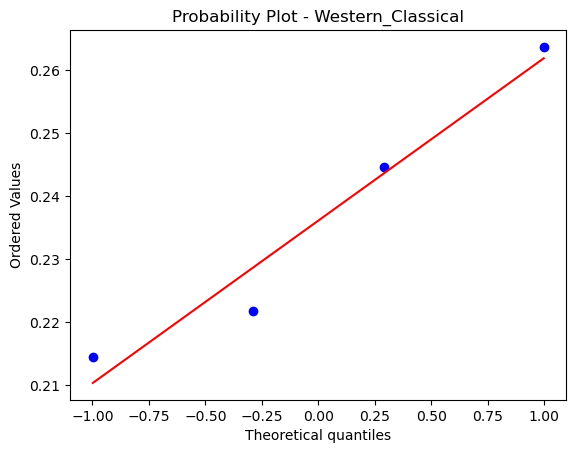

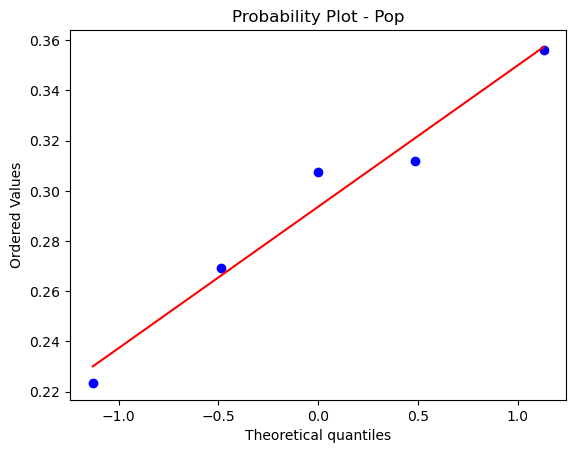

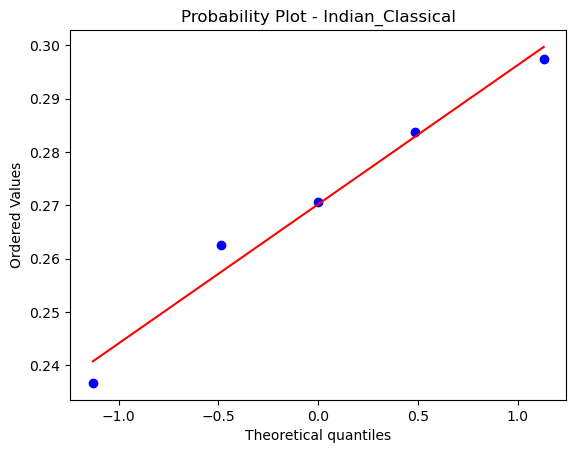

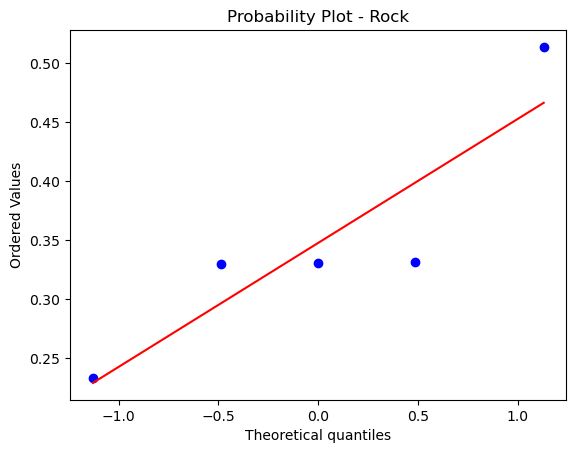

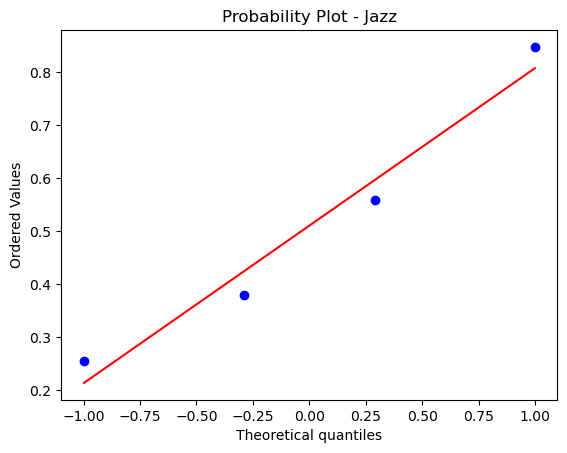

In [46]:
#Normality Check using plots
Genrelist = alldata_df['Genre'].unique()
for Genre in Genrelist:
    stats.probplot(alldata_df[alldata_df['Genre'] == Genre]['combined score'], dist="norm", plot=plt)
    plt.title("Probability Plot - " +  Genre)
    plt.show()

In [111]:
# calculate ratio of the largest to the smallest sample standard deviation
ratio = alldata_df.groupby('Genre').std().max() / alldata_df.groupby('Genre').std().min()
ratio



print('''Homogeneity of Variance Test: 
Ratio of max standard deviation to 
min standard deviation for''', 
      ratio)

Homogeneity of Variance Test: 
Ratio of max standard deviation to 
min standard deviation for combined score    11.457658
dtype: float64


In [112]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Ratios: Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Ratios: Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = alldata_df['combined score'].mean()
SSTR = alldata_df.groupby('Genre').count() * (alldata_df.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (alldata_df.groupby('Genre').count() - 1) * alldata_df.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = alldata_df['Genre'].nunique() - 1
anova_table['df']['Within Groups'] = alldata_df.shape[0] - alldata_df['Genre'].nunique()
anova_table['df']['Total'] = alldata_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], 
                                                           anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

#measure of VARIANCE, NOT ACTUAL SCORES --> two tailed applies to SCORES, but not necessarily variance!!
#Variance is actually skewed!!! Poisson distribution

## possible types "right-tailed, left-tailed, two-tailed"
##tail_hypothesis_type = "two-tailed"
##if tail_hypothesis_type == "two-tailed":
    ##alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

,SS,df,MS,F,P-value,F crit
Ratios: Source of Variation,,,,,,
Between Groups,0.207202,5,0.04144,3.244357,0.025172,2.684781
Within Groups,0.268235,21,0.012773,,,
Total,0.475437,26,0.018286,,,


Approach 1: The p-value approach to hypothesis testing in the decision rule
p-value cutoff: 0.05
F-score is: 3.244356785445615  and p value is: 0.025172083013724533
Null Hypothesis is rejected.


In [104]:
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=alldata_df['combined score'], groups=alldata_df['Genre'], alpha=0.05)
print('''                        For Ratios (Combined Score): 
''', m_comp)

                        For Ratios (Combined Score): 
            Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1            group2      meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------------
Control/No Music  Indian_Classical   0.0117    1.0 -0.2255  0.2489  False
Control/No Music              Jazz   0.2515 0.0482  0.0014  0.5015   True
Control/No Music               Pop   0.0352 0.9969  -0.202  0.2723  False
Control/No Music              Rock   0.0893 0.8423 -0.1479  0.3265  False
Control/No Music Western_Classical  -0.0224 0.9997 -0.2724  0.2276  False
Indian_Classical              Jazz   0.2398 0.0466  0.0026   0.477   True
Indian_Classical               Pop   0.0235 0.9994 -0.2001  0.2471  False
Indian_Classical              Rock   0.0776 0.8816  -0.146  0.3012  False
Indian_Classical Western_Classical  -0.0341 0.9974 -0.2713  0.2031  False
            Jazz               Pop  -0.2163 0.0873 -0.453

Approach 1: The p-value approach to hypothesis testing in the decision rule
p-value cutoff: 0.05
F-score is: 3.244356785445615  and p value is: 0.025172083013724533
Null Hypothesis is rejected.


In [51]:
x = '''
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['salary'].mean()
SSTR = sample_df.groupby('major').count() * (sample_df.groupby('major').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05
# possible types "right-tailed, left-tailed, two-tailed"
tail_hypothesis_type = "two-tailed"
if tail_hypothesis_type == "two-tailed":
    alpha /= 2
anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table

#x = x.replace("major","Genre").replace("salary","combined score").replace("sample_df","alldata_df")
#print(x)
'''


In [52]:
# apply the z-score method in Pandas using the .mean() and .std() methods
def z_score(df):
    # copy the dataframe
    df_normal = df.copy()
    # apply the z-score method
    for column in df.columns:
        if column == "combined score":
            df_normal[column] = (df_normal[column] - df_normal[column].mean()) / df_normal[column].std()
        else: 
            pass
        
    return df_normal
    
#call the z_score function (not needed for t tests, since test accounts for mean and variance already --- Normalization makes all means 0 and variances 1!!!)



In [53]:
jazzdata_df = pd.read_csv("jazz_data.csv")
jazzdata_df = jazzdata_df[['Genre','combined score']]
jazzdata_df = z_score(jazzdata_df)

controldata_df = pd.read_csv("control_nm_data.csv")
controldata_df = controldata_df[['Genre','combined score']]
jazzdata_df = z_score(jazzdata_df)


def readdatacsv(filenamestring):
    df = pd.read_csv(filenamestring)
    a = df.columns[0]
    b = df.columns[1]
    df = df[[a,b]]
    return df

jazzdata_df = readdatacsv("jazz_data.csv")
controldata_df = readdatacsv("control_nm_data.csv")
icdata_df = readdatacsv("ic_data.csv")
wcdata_df = readdatacsv("wc_data.csv")
popdata_df = readdatacsv("pop_data.csv")
rockdata_df = readdatacsv("rock_data.csv")

mydict = {"Control/No Music":controldata_df, "Indian Classical":icdata_df, "Jazz":jazzdata_df, "Pop":popdata_df, "Rock":rockdata_df, "Western Classical":wcdata_df, "All Data":alldata_df}
#for key, value in mydict.items():
   # print("for genre: ", key)
    #display(value)

display(jazzdata_df["combined score"].mean())


0.509999398875

For Ratios:


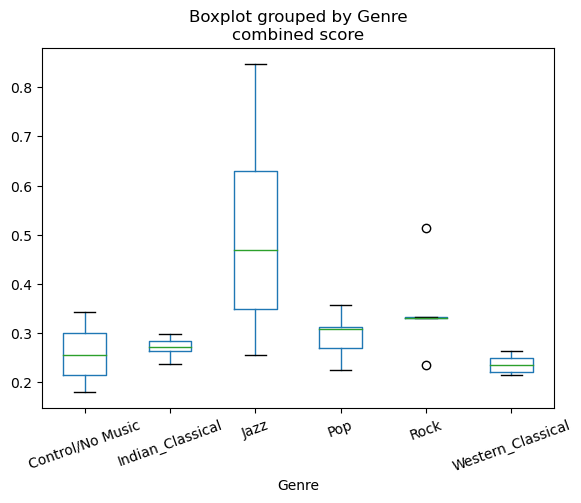

In [115]:
alldataplot = alldata_df.boxplot(by ='Genre', column =['combined score'], grid = False)
alldataplot.plot()
plt.xticks(rotation = 20) # Rotates X-Axis Ticks by 45-degrees
print("For Ratios:")
plt.show()

In [55]:
def myttest(treatmentdata, controldata, combinedscore):
    print("Mean of treatment data: ", treatmentdata[combinedscore].mean())
    print("Mean of control data: ", controldata[combinedscore].mean())
    print("Variance of treatment data: ", treatmentdata[combinedscore].var())
    print("Variance of control data: ", controldata[combinedscore].var())
    testresults = ttest_ind(treatmentdata[combinedscore], controldata[combinedscore], equal_var=False)
    return testresults
#Last two lines tell function to remember what t test values are so that I can put htem in a variable later

In [56]:
#variable jazzttestresults captures stored value and printed sentences   
jazzttestresults = myttest(jazzdata_df, controldata_df, "combined score") 
print(jazzttestresults)

Mean of treatment data:  0.509999398875
Mean of control data:  0.25854052149999995
Variance of treatment data:  0.06602631349536858
Variance of control data:  0.005018570091542181
Ttest_indResult(statistic=1.8868204060695277, pvalue=0.14344820998354055)


In [57]:
wcttestresults = myttest(wcdata_df, controldata_df, "combined score")
print(wcttestresults)

Mean of treatment data:  0.236157883025
Mean of control data:  0.25854052149999995
Variance of treatment data:  0.0005029506533559797
Variance of control data:  0.005018570091542181
Ttest_indResult(statistic=-0.6024373945502679, pvalue=0.5827954616509721)


In [58]:
icttestresults = myttest(icdata_df, controldata_df, "combined score")
print(icttestresults)

Mean of treatment data:  0.27022390746
Mean of control data:  0.25854052149999995
Variance of treatment data:  0.0005268720381068194
Variance of control data:  0.005018570091542181
Ttest_indResult(statistic=0.31680831119516506, pvalue=0.769335952431015)


In [59]:
popttestresults = myttest(popdata_df, controldata_df, "combined score")
print(popttestresults)

Mean of treatment data:  0.29370064645999994
Mean of control data:  0.25854052149999995
Variance of treatment data:  0.0024823698367121595
Variance of control data:  0.005018570091542181
Ttest_indResult(statistic=0.8402197601781094, pvalue=0.437500667466327)


In [60]:
rockttestresults = myttest(rockdata_df, controldata_df, "combined score")
print(rockttestresults)

Mean of treatment data:  0.34783369323999996
Mean of control data:  0.25854052149999995
Variance of treatment data:  0.010388510244688814
Variance of control data:  0.005018570091542181
Ttest_indResult(statistic=1.5468325365131648, pvalue=0.16629619104885798)


In [61]:
data = [["Jazz vs Control", '1.8868204060695277','0.14344820998354055' ],
        ["Rock vs Control", '1.5468325365131648','0.16629619104885798' ], 
        ["WC vs Control", '-0.6024373945502679','0.5827954616509721' ], 
        ["IC vs Control", '0.31680831119516506','0.769335952431015' ], 
        ["Pop vs Control", '0.8402197601781094','0.43750066746632' ]]
ttest_table = pd.DataFrame(data, columns = ["Combined Score: Treatment Data to Control Data","t-statistic", "p-value"])
ttest_table.set_index('Combined Score: Treatment Data to Control Data', inplace = True)
#ttest_table

In [116]:

data = [['Control/No Music', '', '', '', '', '', '', '', ''], ['Indian Classical', '', '', '', '', '', '', '', ''], ['Jazz', '', '', '', '', '', '', '', ''], ['Pop', '', '', '', '', '', '', '', ''], ['Rock', '', '', '', '', '', '', '', ''],['Western Classical', '', '', '', '', '', '', '', ''], ['All Data', '', '', '', '', '', '', '', ''] ] 
desc_stats_table = pd.DataFrame(data, columns = ['Genre', 'Count','Mean', 'STD', 'Min','Q1','Median','Q3', 'Max']) 
desc_stats_table.set_index('Genre', inplace = True)

for key in mydict.keys():
#update count value for each genre
    genrecount = mydict[key]["combined score"].count()
    desc_stats_table["Count"][key] = genrecount    
#update mean in table
    genrecount = mydict[key]["combined score"].mean()
    desc_stats_table["Mean"][key] = genrecount
#update std
    genrecount = mydict[key]["combined score"].std()
    desc_stats_table["STD"][key] = genrecount
#update min
    genrecount = mydict[key]["combined score"].min()
    desc_stats_table["Min"][key] = genrecount
#Q1
    genrecount = mydict[key]["combined score"].quantile(q=0.25)
    desc_stats_table["Q1"][key] = genrecount
#Median
    genrecount = mydict[key]["combined score"].quantile(q=0.5)
    desc_stats_table["Median"][key] = genrecount
#Q3
    genrecount = mydict[key]["combined score"].quantile(q=0.75)
    desc_stats_table["Q3"][key] = genrecount
#max
    genrecount = mydict[key]["combined score"].max()
    desc_stats_table["Max"][key] = genrecount

print("Ratios Descriptive Stats")
desc_stats_table

#for key, value in mydict.items():
   # print("for genre: ", key)
    #descriptivestats_df = value["combined score"].describe()
    #display(descriptivestats_df)

Ratios Descriptive Stats


,Count,Mean,STD,Min,Q1,Median,Q3,Max
Genre,,,,,,,,
Control/No Music,4,0.258541,0.070842,0.180071,0.21466,0.255446,0.299326,0.3432
Indian Classical,5,0.270224,0.022954,0.236703,0.262482,0.270708,0.283822,0.297404
Jazz,4,0.509999,0.256956,0.255097,0.348226,0.468882,0.630655,0.847137
Pop,5,0.293701,0.049823,0.22349,0.269409,0.307675,0.311919,0.356011
Rock,5,0.347834,0.101924,0.233234,0.329986,0.330688,0.331473,0.513788
Western Classical,4,0.236158,0.022427,0.214448,0.219983,0.233223,0.249398,0.263737
All Data,27,0.317688,0.135226,0.180071,0.240661,0.283822,0.331081,0.847137


In [88]:
df_merged = pd.concat([jazzdata_df, controldata_df], ignore_index=True)
x = '''
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['salary'].mean()
SSTR = sample_df.groupby('major').count() * (sample_df.groupby('major').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
anova_table
'''
x = x.replace("major","Genre").replace("salary","combined score").replace("sample_df","df_merged")
print(x)


# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nuniqu

In [89]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Jazz vs Control: Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Jazz vs Control: Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nunique() - 1
anova_table['df']['Within Groups'] = df_merged.shape[0] - df_merged['Genre'].nunique()
anova_table['df']['Total'] = df_merged.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

,SS,df,MS,F,P-value,F crit
Jazz vs Control: Source of Variation,,,,,,
Between Groups,0.126463,1,0.126463,3.560091,0.108128,5.987378
Within Groups,0.213135,6,0.035522,,,
Total,0.339598,7,0.048514,,,


Approach 1: The p-value approach to hypothesis testing in the decision rule
p-value cutoff: 0.05
F-score is: 3.560091244760377  and p value is: 0.10812772317283004
Failed to reject the null hypothesis.


Approach 1: The p-value approach to hypothesis testing in the decision rule
p-value cutoff: 0.05
F-score is: 3.560091244760377  and p value is: 0.10812772317283004
Failed to reject the null hypothesis.


In [82]:
df_merged = pd.concat([popdata_df, controldata_df], ignore_index=True)
x = '''
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['salary'].mean()
SSTR = sample_df.groupby('major').count() * (sample_df.groupby('major').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
'''
x = x.replace("major","Genre").replace("salary","combined score").replace("sample_df","df_merged")
print(x)


# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nuniqu

In [86]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Pop vs Control: Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Pop vs Control: Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nunique() - 1
anova_table['df']['Within Groups'] = df_merged.shape[0] - df_merged['Genre'].nunique()
anova_table['df']['Total'] = df_merged.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

,SS,df,MS,F,P-value,F crit
Pop vs Control: Source of Variation,,,,,,
Between Groups,0.002747,1,0.002747,0.769668,0.409417,5.591448
Within Groups,0.024985,7,0.003569,,,
Total,0.027732,8,0.003467,,,


Approach 1: The p-value approach to hypothesis testing in the decision rule
p-value cutoff: 0.05
F-score is: 0.7696684708485372  and p value is: 0.4094173908045142
Failed to reject the null hypothesis.


In [90]:
df_merged = pd.concat([icdata_df, controldata_df], ignore_index=True)
x = '''
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['salary'].mean()
SSTR = sample_df.groupby('major').count() * (sample_df.groupby('major').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
'''
x = x.replace("major","Genre").replace("salary","combined score").replace("sample_df","df_merged")
print(x)


# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nuniqu

In [92]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Indian Classical vs Control: Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Indian Classical vs Control: Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nunique() - 1
anova_table['df']['Within Groups'] = df_merged.shape[0] - df_merged['Genre'].nunique()
anova_table['df']['Total'] = df_merged.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

,SS,df,MS,F,P-value,F crit
Indian Classical vs Control: Source of Variation,,,,,,
Between Groups,0.000303,1,0.000303,0.123716,0.735389,5.591448
Within Groups,0.017163,7,0.002452,,,
Total,0.017467,8,0.002183,,,


Approach 1: The p-value approach to hypothesis testing in the decision rule
p-value cutoff: 0.05
F-score is: 0.12371568109565516  and p value is: 0.7353890775385175
Failed to reject the null hypothesis.


In [93]:
df_merged = pd.concat([wcdata_df, controldata_df], ignore_index=True)
x = '''
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['salary'].mean()
SSTR = sample_df.groupby('major').count() * (sample_df.groupby('major').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
'''
x = x.replace("major","Genre").replace("salary","combined score").replace("sample_df","df_merged")
print(x)


# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nuniqu

In [94]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Western Classical vs Control: Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Western Classical vs Control: Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nunique() - 1
anova_table['df']['Within Groups'] = df_merged.shape[0] - df_merged['Genre'].nunique()
anova_table['df']['Total'] = df_merged.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

,SS,df,MS,F,P-value,F crit
Western Classical vs Control: Source of Variation,,,,,,
Between Groups,0.001002,1,0.001002,0.362931,0.568936,5.987378
Within Groups,0.016565,6,0.002761,,,
Total,0.017567,7,0.00251,,,


Approach 1: The p-value approach to hypothesis testing in the decision rule
p-value cutoff: 0.05
F-score is: 0.3629308143525159  and p value is: 0.5689359647005867
Failed to reject the null hypothesis.


In [95]:
df_merged = pd.concat([rockdata_df, controldata_df], ignore_index=True)
x = '''
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = sample_df['salary'].mean()
SSTR = sample_df.groupby('major').count() * (sample_df.groupby('major').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['salary'].sum()

# calculate SSE and update anova table
SSE = (sample_df.groupby('major').count() - 1) * sample_df.groupby('major').std()**2
anova_table['SS']['Within Groups'] = SSE['salary'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['salary'].sum() + SSE['salary'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = sample_df['major'].nunique() - 1
anova_table['df']['Within Groups'] = sample_df.shape[0] - sample_df['major'].nunique()
anova_table['df']['Total'] = sample_df.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)
'''
x = x.replace("major","Genre").replace("salary","combined score").replace("sample_df","df_merged")
print(x)


# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nuniqu

In [96]:
# Create ANOVA backbone table
data = [['Between Groups', '', '', '', '', '', ''], ['Within Groups', '', '', '', '', '', ''], ['Total', '', '', '', '', '', '']] 
anova_table = pd.DataFrame(data, columns = ['Rock vs Control: Source of Variation', 'SS', 'df', 'MS', 'F', 'P-value', 'F crit']) 
anova_table.set_index('Rock vs Control: Source of Variation', inplace = True)

# calculate SSTR and update anova table
x_bar = df_merged['combined score'].mean()
SSTR = df_merged.groupby('Genre').count() * (df_merged.groupby('Genre').mean() - x_bar)**2
anova_table['SS']['Between Groups'] = SSTR['combined score'].sum()

# calculate SSE and update anova table
SSE = (df_merged.groupby('Genre').count() - 1) * df_merged.groupby('Genre').std()**2
anova_table['SS']['Within Groups'] = SSE['combined score'].sum()

# calculate SSTR and update anova table
SSTR = SSTR['combined score'].sum() + SSE['combined score'].sum()
anova_table['SS']['Total'] = SSTR

# update degree of freedom
anova_table['df']['Between Groups'] = df_merged['Genre'].nunique() - 1
anova_table['df']['Within Groups'] = df_merged.shape[0] - df_merged['Genre'].nunique()
anova_table['df']['Total'] = df_merged.shape[0] - 1

# calculate MS
anova_table['MS'] = anova_table['SS'] / anova_table['df']

# calculate F 
F = anova_table['MS']['Between Groups'] / anova_table['MS']['Within Groups']
anova_table['F']['Between Groups'] = F

# p-value
anova_table['P-value']['Between Groups'] = 1 - stats.f.cdf(F, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# F critical 
alpha = 0.05

anova_table['F crit']['Between Groups'] = stats.f.ppf(1-alpha, anova_table['df']['Between Groups'], anova_table['df']['Within Groups'])

# Final ANOVA Table
display(anova_table)
# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
conclusion = "Failed to reject the null hypothesis."
if anova_table['P-value']['Between Groups'] <= alpha:
    conclusion = "Null Hypothesis is rejected."
print("p-value cutoff: 0.05")
print("F-score is:", anova_table['F']['Between Groups'], " and p value is:", anova_table['P-value']['Between Groups'])    
print(conclusion)

,SS,df,MS,F,P-value,F crit
Rock vs Control: Source of Variation,,,,,,
Between Groups,0.017718,1,0.017718,2.190941,0.182368,5.591448
Within Groups,0.05661,7,0.008087,,,
Total,0.074328,8,0.009291,,,


Approach 1: The p-value approach to hypothesis testing in the decision rule
p-value cutoff: 0.05
F-score is: 2.190941485834946  and p value is: 0.18236754940807998
Failed to reject the null hypothesis.
